**Note**: scikit-learn 0.25 has been renamed to scikit-learn 1.0.

In [1]:
import pandas as pd
import numpy as np

# Use ColumnTransformer to apply different preprocessing to diff columns

https://stackoverflow.com/questions/65183489/what-is-the-difference-between-columntransformer-and-make-columntransformer

In [2]:
dict_df = {
    'Gender': ['M', 'F', 'F', 'M', 'F', 'F'],
    'Age': [np.random.randint(18, 30) for _ in range(6)],
    'Class': ['first', 'second', 'second', 'first', 'third', 'third']
}

df = pd.DataFrame(dict_df)
df

,Gender,Age,Class
0,M,29,first
1,F,20,second
2,F,24,second
3,M,20,first
4,F,24,third
5,F,18,third


In [3]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [4]:
ohe = OneHotEncoder()

ct = make_column_transformer(
    (ohe, ['Gender']),
    # What to do with the columns that are not specified?
    remainder='passthrough'
)

ct.fit_transform(df)

array([[0.0, 1.0, 29, 'first'],
       [1.0, 0.0, 20, 'second'],
       [1.0, 0.0, 24, 'second'],
       [0.0, 1.0, 20, 'first'],
       [1.0, 0.0, 24, 'third'],
       [1.0, 0.0, 18, 'third']], dtype=object)

One way to select columns is using column names. There are 7 other ways.

## Other ways to select columns in column_transformer

- column name
- integer position
- slice
- boolean mask
- regex pattern
- dtypes to include/exclude

In [5]:
ct = make_column_transformer((ohe, ['Gender']))
ct = make_column_transformer((ohe, [1]))
ct = make_column_transformer((ohe, slice(1, 2)))
ct = make_column_transformer((ohe, [True, False]))

In [6]:
from sklearn.compose import make_column_selector

In [7]:
ct = make_column_transformer((ohe, make_column_selector(dtype_include=object)))
ct = make_column_transformer((ohe, make_column_selector(dtype_exclude='number')))

In [8]:
ct.fit_transform(df)

array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.]])

- <b>ct.get_feature_names_out()</b> gives you the feature names from the column transformer.

- In ColumnTransformer, you can use the strings 'passthrough' and 'drop' in place of a transformer. Useful if you need to passthrough some columns and drop others.

```python
ct = make_column_transformer(
    (impute, ['A', 'B']),
    ('passthrough', ['C', 'D']),
    remainder='drop'
)
```

# Difference between fit and transform

- <b>"fit"</b> is when the transformer learns something about the data.
- <b>"transform"</b> is when it uses what it learned to do the data transformation.
- Use ```fit_transform()``` on training data but ```transform()``` only on testing data.


<b>Example:</b>
```SimpleImputer``` : fit learns the value to impute. transform fills in the missing entries using the imputation value.

<b><u>Important: </u></b> Use "fit_transform" on training data, but "transform" only on testing/new data. New data is out of sample data.

# Why use scikit-learn for ML preprocessing?
- You can cross-validate the entire workflow.
- You can grid search model & preprocessing hyperparameters. You can use it to search for the pre-processing hyperparameters as well as the model hyperparameters. Ex: C of logR and imputation method for some columns.
- Avoids adding new columns to the source dataframe.
- pandas lacks separate fit/transform steps to prevent data leakage.

<b>Tip:</b>You do not need to use .values when passing a dataframe or series to scikit-learn. It knows how to access the underlying Numpy arrays.

# Loading toy datasets

Need to load a toy dataset into a DataFrame including column names? Set ```as_frame=True```

In [9]:
from sklearn.datasets import load_iris

In [10]:
# return Dataframe with features and target
df_toy = load_iris(as_frame=True)['frame']
df_toy.sample(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
12,4.8,3.0,1.4,0.1,0
65,6.7,3.1,4.4,1.4,1


In [11]:
# return dtaframe with features and series with target
X, y = load_iris(as_frame=True, return_X_y=True)
X.sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
47,4.6,3.2,1.4,0.2
34,4.9,3.1,1.5,0.2
53,5.5,2.3,4.0,1.3


# Encoding categorical features

- OHE for nominal (unordered) data
- Ordinal Encoder for ordingal (ordered) data

<b>Note:</b> Label encoder is for labels, not features.

In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [13]:
df.sample()

,Gender,Age,Class
2,F,24,second


In [14]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(df[['Gender']])

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [15]:
oe = OrdinalEncoder(categories=[['first', 'second', 'third']])
oe.fit_transform(df[['Class']])

array([[0.],
       [1.],
       [1.],
       [0.],
       [2.],
       [2.]])

- Label Encoder is for labels (target).
- Label Encoder & Ordinal Encoder works similar except you cannot define the ordering and you can only encode one thing at a time. In OE, you can encode multiple features at a time.
- Therefore, scikit learn documents suggest explicit usage against Label encoder for features.

## For a OHE feature, what can you do if new data contains categories that were not seen during training?

- Set ```handle_unknown=ignore``` to encode new categories as all zeroes.

- If you know all possible categories that might ever appear, you can instead specify the categories manually. ```handle_unknown=ignore``` is useful specifically when you don't know all possible categories.

- This however treats every other category that OHE has not seen as belonging to "other" category. This indicates that all other categories that may appear have the same weight.

- Ideally, once you set this, you always come back to your pipeline and retrain your model once you know the previously unknown categories.

- This is particularly useful when the certain categories in a feature are infrequent. It is possible that they do not appear in the training set but appear in the testing set because of their low frequency.

In [16]:
df_ohe = pd.DataFrame(['A', 'B', 'C', 'B'], columns=['col'])
df_ohe

,col
0,A
1,B
2,C
3,B


In [17]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit_transform(df_ohe[['col']])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [18]:
X_new = pd.DataFrame(['A', 'D', 'D'], columns=['col'])
X_new

,col
0,A
1,D
2,D


In [19]:
ohe.transform(X_new[['col']])

array([[1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

## Recommended not to use ```drop='first'``` with OneHotEncoder because:
- Multicollinearity is rarely an issue with scikit-learn mdoels.
- drop='first' is incompatible with ```handle_unknown='ignore'```. handle_unknown encodes all unseen categories as 0s; drop=first will encode your first category as all 0s. Scikit learn therefore does not allow encoding them both the same way.
- May be problematic if you standardize all features or use a regularized model. If we are goind to use standard scalar on all columns including the ones that are one hot encoded, it does not seem right to do standardization after dropping a level, because the column that was dropped should ideally be standardized too. It was okay to drop when the first level was redundant, however, once you change the numerical value of other categories, the category you dropped does not seem like redundant anymore. One solution to avoid this is to use standard scalar on numeric columns and leave the OHE columns as they are.

## Use ```drop='if_binary'``` with OHE to drop the first category ONLY if it is a binary feature.

In [20]:
df_testing = df[['Gender', 'Class']]
df_testing

,Gender,Class
0,M,first
1,F,second
2,F,second
3,M,first
4,F,third
5,F,third


In [21]:
ohe = OneHotEncoder(sparse=False, drop=None)
ohe.fit_transform(df_testing)

array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.]])

In [22]:
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit_transform(df_testing)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [23]:
ohe = OneHotEncoder(sparse=False, drop='if_binary')
# Notice that Gender's one column is dropped. However, class does not drop 
# any columns
ohe.fit_transform(df_testing)

array([[1., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

## With a tree based model, try OrdinalEncoder instead of OneHotEncoder even for nominal features.

<b>Accuracy will often be similar, but OrdinalEncoder will be much faster.</b>

# Missing values

<b>Note: Beginning in scikit-learn 0.24, OneHotEncoder can handle missing values (without the use of SimpleImputer) by treating them as a separate category.</b>

## Preserve information about which values were missing and use that as a feature!

Sometimes, there is a relationship between "missingness" and the target/label you are trying to predict. 

In [24]:
x_miss_test = pd.DataFrame([20, 30, 10, np.nan, 10], columns=['age'])
x_miss_test

,age
0,20.0
1,30.0
2,10.0
3,NaN
4,10.0


In [25]:
from sklearn.impute import SimpleImputer

# impute mean
imputer_obj = SimpleImputer()
imputer_obj.fit_transform(x_miss_test)

array([[20. ],
       [30. ],
       [10. ],
       [17.5],
       [10. ]])

In [26]:
# impute mean and add an indicator matrix
imputer_obj = SimpleImputer(add_indicator=True)
imputer_obj.fit_transform(x_miss_test) 

array([[20. ,  0. ],
       [30. ,  0. ],
       [10. ,  0. ],
       [17.5,  1. ],
       [10. ,  0. ]])

You can also use ```MissingIndicatorClass``` from scikit-learn.

## Better ways to impute other than SimpleImputer

Trying KNNImputer or IterativeImputer.
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [27]:
x_miss_test = pd.DataFrame(
    {
        'fare': [7.25, 71.2, 15.88, 50, 10, 15, 50],
        'age': [20, 38, 10, np.nan, 19, 15, np.nan] 
    }
)
x_miss_test

,fare,age
0,7.25,20.0
1,71.20,38.0
2,15.88,10.0
3,50.00,NaN
4,10.00,19.0
5,15.00,15.0
6,50.00,NaN


In [28]:
# still "experimental" so it must be enabled explicitly
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [29]:
impute_it = IterativeImputer()
impute_it.fit_transform(x_miss_test)

array([[ 7.25      , 20.        ],
       [71.2       , 38.        ],
       [15.88      , 10.        ],
       [50.        , 28.77922408],
       [10.        , 19.        ],
       [15.        , 15.        ],
       [50.        , 28.77922408]])

In [30]:
from sklearn.impute import KNNImputer

In [31]:
impute_knn = KNNImputer(n_neighbors=2)
impute_knn.fit_transform(x_miss_test)

array([[ 7.25, 20.  ],
       [71.2 , 38.  ],
       [15.88, 10.  ],
       [50.  , 24.  ],
       [10.  , 19.  ],
       [15.  , 15.  ],
       [50.  , 24.  ]])

- Simple Imputer is univariate in nature meaning it only takes a single feature into account. What if "age" was well correlated with other features like fare, meaning high fare should correspond to a high age and vice-versa? This requires a multi-variate approach which is taken care of by both Iterative imputer and KNNImputer.

- <b>IterativeImputer</b> checks all the rows for which the age value is not null, scikit trains a regression model using "fair" as feature and "age" as target. You can pick the regression model.

- With <b>KNN imputer</b>, for every row where "age" is missing, scikit-learn finds the two most (n_neighbors=2) similar rows measure by how close the "fair" value is to this row.

- NOTE: Both imputers can <b>only impute numeric features</b> and can only take numeric features as input.

Q) Which features are taken into account by IterativeImpure and KNNImputer?

<pre>
Any features that you pass to the imputer are taken into account.
</pre>

## HistGradientBoostingClassifier natively handles missing values.

The model does not Impute missing values not does it drop the necessary rows or columns. 

## Two ways to impute missing values for a categorical feature

- Impute the most frequent value. Impute in the proportion that the values appear.
- Impute the value "missing", which treats it as a seperate category.

In [32]:
shape = pd.DataFrame(['square', 'square', 'oval', np.nan, 'circle'])
shape

,0
0,square
1,square
2,oval
3,NaN
4,circle


In [33]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit_transform(shape)

array([['square'],
       ['square'],
       ['oval'],
       ['square'],
       ['circle']], dtype=object)

<b>THe following strategy makes most sense theoretically because it is sort of adding a missing value indicator.</b>

In [34]:
imputer = SimpleImputer(strategy='constant', fill_value='missing')
imputer.fit_transform(shape)

array([['square'],
       ['square'],
       ['oval'],
       ['missing'],
       ['circle']], dtype=object)

# Pipelines

<b>scikit-learn now accepts string values for the target column, as long as you are using a classification model.</b>

## Use Pipeline() to chain together multiple steps

- Chains together multiple steps: output of each step is used as input to the next step.

- Makes it easier to apply the same pre-processing to both train and test.

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [36]:
imputer = SimpleImputer()
clf = LogisticRegression()

In [37]:
X, y = df_toy.drop(columns=['target']), df_toy['target']
X.shape

(150, 4)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(105, 4)

In [39]:
pipe = make_pipeline(imputer, clf)

In [40]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression())])

In [41]:
# pipeline applies the impute to X_new before making predictions 
# pipeline uses imputation values learned during the "fit" step
pipe.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0])

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
accuracy_score(y_test, pipe.predict(X_test))

1.0

## Pipeline() v/s make_pipeline()

Same applies to ```make_column_transformer``` and ```ColumnTransformer()```

```make_pipeline``` does not require you to name your steps. ```Pipeline()``` does.

In [44]:
df

,Gender,Age,Class
0,M,29,first
1,F,20,second
2,F,24,second
3,M,20,first
4,F,24,third
5,F,18,third


In [45]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [46]:
# you pass tuples of length 2 and any necessary arguments 
# at the end
ct = make_column_transformer(
    (OneHotEncoder(), ['Gender']),
    (SimpleImputer(), ['Age']),
    remainder='passthrough'
)

# you pass the transformer and model objects
pipe = make_pipeline(ct, LogisticRegression())

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [48]:
# you pass a list of tuples and any necessary arguments.
# each tuple is of length 3 where the first argument is 
# the step name you assign for the operation
ct_ = ColumnTransformer(
    [
        ('encoder', OneHotEncoder(), ['Gender']),
        ('imputer', SimpleImputer(), ['Age'])
    ],
    remainder='passthrough'
)

pipe_ = Pipeline(
    [('pre-processor', ct_), ('classifier', LogisticRegression())]
)

The order of transformers within a ColumnTransformer does not matter, because the transformers operate in parallel. In other words, the output of one transformer does not become the input to another transformer. In contrast, the order of steps within a Pipeline does matter, because the output of each step becomes the input to the next step. Thus you can think of a Pipeline as running in sequence, whereas a ColumnTransformer runs in parallel. 

## Examine the intermediate steps in a Pipeline()

- We do that by using "named_steps" attribute.

```pipe.named_steps.STEP_NAME.ATTRIBUTE```

In [49]:
df_pipe_ex = pd.DataFrame(
    {
        'Age': [22, 23, 19, np.nan, 35, np.nan],
        'Pclass': [3, 1, 3, 1, 3, 3],
        'Survived': [0, 1, 1, 1, 0, 0]
    }
)
df_pipe_ex

,Age,Pclass,Survived
0,22.0,3,0
1,23.0,1,1
2,19.0,3,1
3,NaN,1,1
4,35.0,3,0
5,NaN,3,0


In [50]:
X, y = df_pipe_ex[['Age', 'Pclass']], df_pipe_ex['Survived']

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [52]:
pipe = make_pipeline(SimpleImputer(), LogisticRegression())
# You can use semicolon to suppress output in IPython
pipe.fit(X, y);

In [53]:
# inspect the imputation values for "Age" and "Pclass"
# mean is the simple imputer default strategy
pipe.named_steps.simpleimputer.statistics_

array([24.75      ,  2.33333333])

In [54]:
# display the model coefficients for "Age" and "Pclass"
pipe.named_steps.logisticregression.coef_

array([[-0.40361272, -0.98200262]])

## Use the correct method for each type of Pipeline

- There are two types of Pipelines available. The Pipeline type determines which methods you can use with it, and what those methods actually do.
    - ```pipe.fit()```: All steps before the final run fit_transform(), and the final steps run fit()
    - ```pipe.predict()```: All steps before the final one run transform(), and the final step run predict()
<br>
- If a Pipeline ends in a classifier or regressor, you can use the fit() and transform() methods. - pipe
    - ```pipe.fit_transform()```: All steps run fit_transform()
    - ```pipe.transform()```: All steps run transform()
<br>
- If a Pipeline ends in a <b>transformer</b>, you can use the fit_transform() and transform() methods

## Save a model or Pipeline

Use ```joblib``` with the caution that you must load in into an identical environment, and load objects you trust.

```python
# save the pipeline to a file
import joblib
joblib.dump(pipe, 'pipe_desc.joblib')

# load the pipeline from a file
pipe_load = joblib.load('pipe_desc.joblib')
pipe_load.predict(X_test)
```

Very similar to ```pickle```. Specifically optimized for numpy arrays used by scikit learn.

## Examine the steps of a Pipeline

In [55]:
df

,Gender,Age,Class
0,M,29,first
1,F,20,second
2,F,24,second
3,M,20,first
4,F,24,third
5,F,18,third


In [56]:
ct_ = ColumnTransformer(
    [
        ('encoder', OneHotEncoder(), ['Gender']),
        ('imputer', SimpleImputer(), ['Age'])
    ],
    remainder='passthrough'
)

pipe_ = Pipeline(
    [('pre-processor', ct_), ('classifier', LogisticRegression())]
)

In [57]:
X, y = df[['Gender', 'Age']], df['Class']
pipe_.fit(X, y)

Pipeline(steps=[('pre-processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OneHotEncoder(),
                                                  ['Gender']),
                                                 ('imputer', SimpleImputer(),
                                                  ['Age'])])),
                ('classifier', LogisticRegression())])

<b>4 ways to display the model coefficients.</b>

In [58]:
# pipeline-object-name.named_steps.step_name.attribute
pipe_.named_steps.classifier.coef_

array([[-0.665074  ,  0.66508016,  0.10827982],
       [ 0.34355932, -0.34356601,  0.00241292],
       [ 0.32151468, -0.32151415, -0.11069274]])

In [59]:
pipe_.named_steps['classifier'].coef_

array([[-0.665074  ,  0.66508016,  0.10827982],
       [ 0.34355932, -0.34356601,  0.00241292],
       [ 0.32151468, -0.32151415, -0.11069274]])

In [60]:
pipe_['classifier'].coef_

array([[-0.665074  ,  0.66508016,  0.10827982],
       [ 0.34355932, -0.34356601,  0.00241292],
       [ 0.32151468, -0.32151415, -0.11069274]])

In [61]:
# step-by position. Step number in the pipeline
pipe_[1].coef_

array([[-0.665074  ,  0.66508016,  0.10827982],
       [ 0.34355932, -0.34356601,  0.00241292],
       [ 0.32151468, -0.32151415, -0.11069274]])

## Add feature selection to a Pipeline

- Use SelectPercentile to keep the highest scoring features.
- Add feature selection after preprocessing but before model building.

Make sure to tune the percentile values.

https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [62]:
# Pipeline with feature selection
from sklearn.feature_selection import SelectPercentile, chi2

# keep 50% of features with the best chi-squared scores
selection_50 = SelectPercentile(chi2, percentile=50)

pipe = make_pipeline(OneHotEncoder(), selection_50, LogisticRegression())

# cross_val_score(pipe, training_x, training_y, scoring='accuracy').mean()

## Create interactive diagrams of a Pipeline in Jupyter

You can even export the diagram to an HTML file. You can also use diagram functionality for column transformers, individual transformers, individual models etc.

In [63]:
# display estimators as diagrams
from sklearn import set_config
set_config(display='diagram')

In [64]:
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function chi2 at 0x00000172BADD0EE0>)),
                ('logisticregression', LogisticRegression())])

In [65]:
pipe_

Pipeline(steps=[('pre-processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OneHotEncoder(),
                                                  ['Gender']),
                                                 ('imputer', SimpleImputer(),
                                                  ['Age'])])),
                ('classifier', LogisticRegression())])

In [66]:
# export the diagram 
# from sklearn.utils import estimator_html_repr
# with open('pipeline_diag.html', 'w') as f:
#     f.write(estimator_html_repr)

## Slice Pipeline to access part of it

In [67]:
pipe[0:2]

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function chi2 at 0x00000172BADD0EE0>))])

<b>Which features were chosen by the feature selection step?</b>

In [68]:
pipe[0:2].fit_transform(X, y)

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

4 features were selected by the feature selection steps. <6X4><br>
Feature selection step requires knowledge of the target variable.

In [69]:
X.shape

(6, 2)

In [70]:
# to know which features were selected
pipe[1].get_support()

array([False,  True,  True, False, False,  True])

## Pattern to solve many ML problems

A simple pattern that can be adadpted to solve many ML problems. It has a few shortcomings but can work very well as-is in plently of situations.

<b>Shortcomings: </b>

- Assumes all columns have proper data types.

- May include irrelevant or improper features.

- Does not handle text or date columns well.

- Ordinal encoding may be better.

- Other imputation strategies may be better.

- Numeric features may not need scaling.

- A different model may be better.

etc.

In [71]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [72]:
# set up pre-processing for numeric columns
imp_median = SimpleImputer(strategy='median', add_indicator=True)
scaler = StandardScaler()

In [73]:
# set up pre-processing for categorical columns
imp_constant = SimpleImputer(strategy='constant')
ohe = OneHotEncoder(handle_unknown='ignore')

In [74]:
# select columns by data-type
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')

In [75]:
# chain all pre-processing steps
preproc = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols)
)

In [76]:
# create a pipeline and cross-validate
pipe = make_pipeline(preproc, LogisticRegression())
# cross_val_score(pipe, X, y, cv=2).mean()
# pipe.fit(X, y)
# pipe.predict(X_new)

# Parameter tuning

## Using cross_val_score and GridSearchCV on a Pipeline

Pre-processing steps will automatically occur AFTER each cross-validation split, which is critical if you want meaningful scores.

<b>Note:</b>  CROSS VAL SCORE splits the data FIRST and then applies the pipeline steps. The alternative which is pre-processing the data first and then use cross validation on just the model is not the right thing to do. The reason in short is pre-processing before splitting the data does not simulate reality. And the whole point of cross_val_score is to simulate reality as close as possible.
<br>
Long answer:
- Any model evaluation procedure assumes that the future will be like the past, and that is rarely 100% true.

- Many parameter combinations may be equally good, and the one that is chosen as "best" by grid search is influenced by which samples happen to appear in each fold of cross-validation. 

- There are variations of cross-validation which can produce even more reliable results, such as repeated cross-validation. 

- We didn't set aside an independent test set, which may be beneficial depending on your goals.

<b>Cross validate the pipeline</b>

In [77]:
# the proper way to do it.
# here cross_val splits the data into 5 parts. 4 to fit and 1 to test.
# on the 4 fits, it uses the column transformer to prepare the data and train the model.
# on 1 fit, it uses the column transformer to prepare the data and makes predictions using
# the trained model. It evaluates the accuracy of that model.
# It repeats the process 4 more times, so we get 5 cross validation scores.
# cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

<b>GridSearch the pipeline</b>

In [78]:
# specify parameter values to search
params = {}
# the tricky part here is you need to specify the step name
# as well as the parameter name.
# Correct way: column_transformer__name of the pre-processor in lower case__name of the hyperparameter
params['columntransfomer__simpleimputer__strategy'] = ['mean', 'median']
params['logisticregression__C'] = [0.1, 1, 10]
params['logisticregression__penalty'] = ['l1', 'l2']

```python
# try all possible combinations of the parameter values
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
grid.fit(X, y);

# what was the best score?
grid.best_score_

# which combinations of parameters produced the best score?
grid.best_params_
```

## Try ```RandomizedSearchCV``` if GridSearchCV is taking too long

If GSCv is taking too long, you might want to try RandomizedSearchCV with a small number of iterations. Make sure to specify a distribution (instead of a list of values) for continuous parameters!

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [80]:
pipe = make_pipeline(CountVectorizer(), MultinomialNB())

```python
# cross validate the pipeline using default parameters
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()
```

In [81]:
# specify parameter values to search (use a distribution for any continous parameters)
import scipy as sp
params = {}

params['countvectorizer__min_df'] = [1, 2, 3, 4]
params['countvectorizer__lowercase'] = [True, False]
params['multinomialnb__alpha'] = sp.stats.uniform(scale=1)

In [82]:
# try "n_iter" random combinations of those parameter values
from sklearn.model_selection import RandomizedSearchCV
# Run the RSCV 290 times (n_iter)
rand = RandomizedSearchCV(pipe, params, n_iter=20, cv=5, scoring='accuracy', random_state=1)
# rand.fit(X, y)
# rand.best_score_
# rand.best_params_

- In RSCv, you control the computational budget explicitly.

- Sometimes, the optimal parameters are <u>in </u>between the evenly spaced GridSearch list that you may specify. This is the reason why we specified a distribution for the continous features.

## Display GScv or RScv results in a dataframe.

```python
# convert results into a DataFrame
results = pd.DataFrame(grid.cv_results_)
results.sort_values('rank_test_score')
```

## Imoprtant runing parameters of LogisticRegression

- C: inverse of regularization strength
- penalty: type of regularization
- solver: algorithm used for optimization

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

## Prune a decision tree to avoid overfitting

- uses cost-complexity pruning.
- increase ```ccp_alpha``` to increase purning (default=0)

https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

## Estimators only print the parameters that are *not* set to their default values.

You can still see all parameters with ```get_params()```, or restore the previous behaviour with ```set_config()```

In [83]:
clf = LogisticRegression(C=0.1, solver='liblinear')
clf

LogisticRegression(C=0.1, solver='liblinear')

In [84]:
# inspecting clf, we notice that it only prints parameters that have been changed from their default values
# see all parameters
clf.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [85]:
# restore behaviour to make it show all
from sklearn import set_config
set_config(print_changed_only=False)
clf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Speed up GridSearchCV using parallel processing

Set ```n_jobs=-1``` to use parallel processing with all CPUs

## You can tune 2+ models using the same grid search! Here's how:

- Create multiple parameter dictionaries.
- Specify the model within each dictionary.
- Put the dictionaris in a list.

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [87]:
ct = make_column_transformer(
    (OneHotEncoder(), ['Sex']),
    (CountVectorizer(), ['Name']),
    (SimpleImputer(), ['Age'])
)

In [88]:
# each of the two models will take a turn as the second pipeline step
clf1 = LogisticRegression(solver='liblinear', random_state=1)
clf2 = RandomForestClassifier(random_state=1)

In [89]:
# create the Pipeline
pipe = make_pipeline(ct, clf1)

In [90]:
# Create param dictionary for clf1
params1 = {}
params1['columntransformer__countvectorizer__ngram_range'] = [(1, 1), (1, 2)]
params1['logisticregression_penalty'] = ['l1', 'l2']
params1['logisticregression_C'] = [0.1, 1, 10]
params1['logisticregression'] = [clf1]

In [91]:
# Create param dictionary for clf1
params2 = {}
params2['columntransformer__countvectorizer__ngram_range'] = [(1, 1), (1, 2)]
params2['randomforestclassifer__n_estimators'] = ['l1', 'l2']
params2['randomforestclassifer__min_samples_leaf'] = [1, 2]
params2['randomforestclassifer'] = [clf2]

In [92]:
# create a list of parameter dictionaries
params = [params1, params2]

# search every parameter combination within each dictionary
grid = GridSearchCV(pipe, params)
# grid.fit(X, y)

# Model Evaluation

## Plot a confusion matrix

https://matplotlib.org/stable/gallery/color/colormap_reference.html

https://docs.python.org/3/library/string.html#format-specification-mini-language

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5)
ct = make_column_transformer((OneHotEncoder(), ['Gender']), remainder='passthrough')
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                max_categories=None,
                                                                min_frequency=None,
                                                                sparse=True),
                                                  ['Gender'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

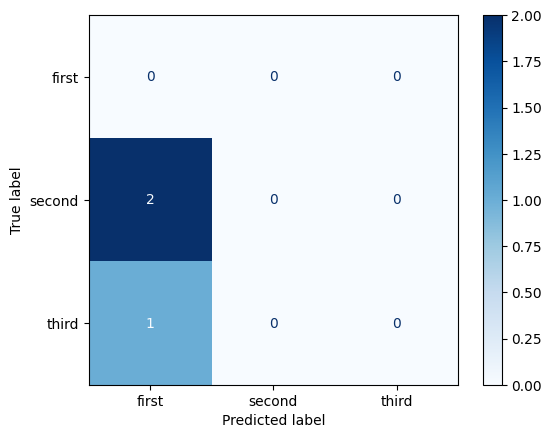

In [95]:
disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues', values_format='.3g')

In [96]:
disp.confusion_matrix

array([[0, 0, 0],
       [2, 0, 0],
       [1, 0, 0]], dtype=int64)

## Compare multiple ROC curves in a single plot

Easily compare multiple ROC curves in a single plot. Automatically displays the AUC for each model as well.

<b>You can only plot an ROC curve for a binary classifier</b>

In [97]:
import pandas as pd

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

In [99]:
df = pd.read_csv('titanic.csv')
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
637,638,0,2,"Collyer, Mr. Harvey",male,31.0,1,1,C.A. 31921,26.2500,NaN,S
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S
836,837,0,3,"Pasic, Mr. Jakob",male,21.0,0,0,315097,8.6625,NaN,S


In [100]:
cols = ['Pclass', 'Fare', 'SibSp']
X = df[cols]
y = df['Survived']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [102]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [103]:
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

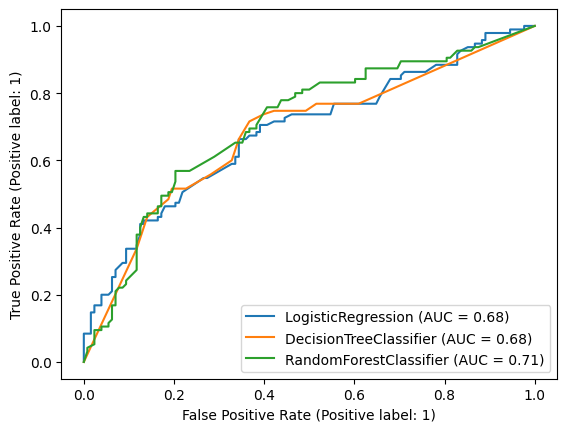

In [104]:
disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)
RocCurveDisplay.from_estimator(dt, X_test, y_test, ax=disp.ax_);
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=disp.ax_)

## Use stratified sampling with train_test_split

In [105]:
df = pd.DataFrame({'feature':list(range(8)), 'target':['not fraud']*6 + ['fraud']*2})
X = df[['feature']]
y = df['target']

In [106]:
from sklearn.model_selection import train_test_split

<b>Not stratified</b>

```y_train``` contains None of the minority classes, whereas y_test contains ALL of the minority class.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
y_train

3    not fraud
0    not fraud
5    not fraud
4    not fraud
Name: target, dtype: object

In [108]:
y_test

6        fraud
2    not fraud
1    not fraud
7        fraud
Name: target, dtype: object

**This is very bad.**

<b>Stratified</b>

Doing this makes sure that the class proportions are SAME in y_train and y_test.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)
y_train

1    not fraud
7        fraud
2    not fraud
4    not fraud
Name: target, dtype: object

In [110]:
y_test

3    not fraud
6        fraud
0    not fraud
5    not fraud
Name: target, dtype: object

## Shuffle your dataset when using cross_val_score

If we use cross-validation and the samples are NOT in an arbitrary order, shuffling may be required to get meaningful results.

https://scikit-learn.org/stable/modules/cross_validation.html#k-fold

https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold

Normally when we use cv, we pass an integer, cv=n, to do a n-fold cv. But one thing to note is this does not shuffle the sample while splitting. Meaning, let's say if we have a 100 rows in X and we use cross_val_score with cv=5 then rows 1:20 of X will be in the test fold while rows 21-100 will be in the training fold. In the next iteration, 21:40 will be in the test fold  and remaining in the training fold... and so on. So there is no shuffling. That is why we get the same cross validation score every time we run it because there is nothing random about the cross_val process.

<br>

<b>Do we need to shuffle?</b>
<br>
If the rows are not in an arbitrary order, then YES you should shuffle. Shuffling a dataset with arbitrary rows will not make a difference.
<br>
Let's say your dataset is sorted by the target value (say 0s and 1s) and all the 0s are at the beginning followed by the 1s, you should definitely shuffle.

In [111]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score

In [112]:
# set up the regression problem
X_reg, y_reg = load_diabetes(return_X_y=True)
reg = LinearRegression()

In [113]:
df = pd.read_csv('titanic.csv')
X_clf = df[['Pclass', 'Fare', 'SibSp']]
y_clf = df['Survived']
clf = LogisticRegression()

In [114]:
from sklearn.model_selection import KFold, StratifiedKFold

<b>Use KFold with regression problems:</b>

In [115]:
# we use a cross validation iterator
# set shuffle=True for shuffling
kf = KFold(5, shuffle=True, random_state=1)
cross_val_score(reg, X_reg, y_reg, cv=kf, scoring='r2')

array([0.43843162, 0.38982359, 0.52792629, 0.47359827, 0.5744937 ])

<b>Use StratifiedKFold with classification problems.</b>

Stratification is when you preserve the class proportions within each fold. Does not make sense for regression problems.

In [116]:
skf = StratifiedKFold(5, shuffle=True, random_state=1)
cross_val_score(clf, X_clf, y_clf, cv=skf, scoring='accuracy')

array([0.65363128, 0.7247191 , 0.66853933, 0.68539326, 0.65730337])

## Use AUC to evaluate multiclass problems.

AUC is an excellent evaluation metric for binary classification, especially if you have class imbalance. 
<br>
AUC can be used with multiclass problems. Supports "one-vs-one" and "one-vs-rest" strategies.

https://scikit-learn.org/stable/modules/model_evaluation.html#multi-class-case

In [117]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)

# only keep two features in order to make this problem harder
X = X[:, 0:2]

In [118]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

<b>Multiclass AUC with train/test split</b>

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

In [121]:
# use 'ovo' (One-vs-One) or 'ovr' (One-vs-Rest)
roc_auc_score(y_test, y_score, multi_class='ovo')

0.9399801587301587

<b>Multiclass AUC with cross-validation.</b>

In [122]:
from sklearn.model_selection import cross_val_score

In [123]:
# use 'roc_auc_ovo' (One-vs-One) or 'roc_auc_ovr' (One-vs-Rest)
cross_val_score(clf, X, y, cv=5, scoring='roc_auc_ovo').mean()

0.9086960878627546

**Regarding the ROC AUC on imbalanced data i often go back to this article: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/ In my opinion the most relevant section of this long article is towards the end "ROC and Precision-Recall Curves With a Severe Imbalance" which shows how ROC AUC can sometimes be misleading (painting a rather optimistic picture) compared to PR. Any thoughts?**

 If a model has a high AUC score, then it is actually performing well at the task AUC is measuring, which is "how well is the model doing at giving higher predicted probabilities to the positive instances than to the negative instances." The fact that the logistic regression model (in that article) is always predicting the majority class is not at all in conflict with the fact that it has an AUC of 0.869. That's because those class predictions use the default classification threshold of 0.5, whereas an ROC curve (and thus AUC) is calculated across all possible thresholds. The high AUC tells me that the model can become useful (meaning it will make useful predictions) simply by adjusting the classification threshold. In summary, I wouldn't view the AUC score itself as misleading. Instead, I would just give the caveat that a model with a high AUC may need threshold tuning in order to make useful class predictions. (And by the way: In some situations you are only concerned with ranking predicted probabilities and not with class predictions. For those situations, AUC is the perfect metric and no threshold tuning is required!)

# Model inspection

## Display the intercept and coefficients for a linear model?

In [124]:
from sklearn.datasets import load_diabetes
dataset = load_diabetes()

In [125]:
X, y = dataset.data, dataset.target
features = dataset.feature_names

In [126]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                 normalize='deprecated', positive=False)

In [127]:
model.intercept_

152.13348416289597

In [128]:
model.coef_

array([ -10.0098663 , -239.81564367,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])

In [129]:
# display the feature names with the coefficients
list(zip(features, model.coef_))

[('age', -10.009866299810438),
 ('sex', -239.81564367242362),
 ('bmi', 519.8459200544605),
 ('bp', 324.3846455023237),
 ('s1', -792.1756385522301),
 ('s2', 476.73902100525765),
 ('s3', 101.0432679380335),
 ('s4', 177.06323767134683),
 ('s5', 751.273699557104),
 ('s6', 67.62669218370519)]

## Visualize a decision tree two different ways
<ol>
    <li>plot_tree: uses matplotlib</li>
    <li>export_text: does not require any external libraries</li>
</ol>

In [130]:
df = pd.read_csv('titanic.csv')
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
features = ['Pclass', 'Fare', 'Sex']

X = df[features]
y = df['Survived']

classes = ['Deceased', 'Survived']

In [131]:
X.isna().sum()

Pclass    0
Fare      0
Sex       0
dtype: int64

In [132]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=2, random_state=1)
dt.fit(X, y);

In [133]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text  # both are new in 0.21

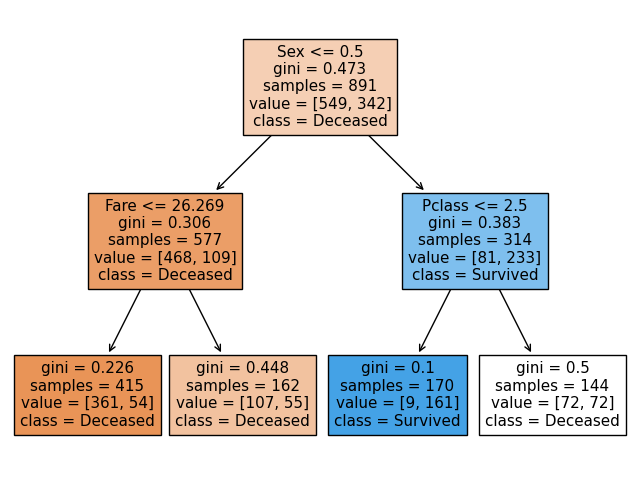

In [134]:
plt.figure(figsize=(8, 6))
# rule is True, you go left of the tree
# rule is False, you go right of the tree
plot_tree(dt, feature_names=features, class_names=classes, filled=True);

The color coding is based on the Gini Impurity. Darker means more pure. The bottom right node is white meaning it is perfectly split between the classes. This can only be used in a single tree and not an ensemble of trees like Random Forests. 

In [135]:
print(export_text(dt, feature_names=features, show_weights=True))

|--- Sex <= 0.50
|   |--- Fare <= 26.27
|   |   |--- weights: [361.00, 54.00] class: 0
|   |--- Fare >  26.27
|   |   |--- weights: [107.00, 55.00] class: 0
|--- Sex >  0.50
|   |--- Pclass <= 2.50
|   |   |--- weights: [9.00, 161.00] class: 1
|   |--- Pclass >  2.50
|   |   |--- weights: [72.00, 72.00] class: 0



# Model Ensembling

## To improve your classifier's accuracy, create multiple models and ensemble them using VotingClassifier!

VotingRegressor is also available.

https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

In [136]:
X.sample()

,Pclass,Fare,Sex
801,2,26.25,1


In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score

In [138]:
lr = LogisticRegression(solver='liblinear', random_state=11)
cross_val_score(lr, X, y).mean()

0.7822547234950725

In [139]:
rf = RandomForestClassifier(max_features=None, random_state=11)
cross_val_score(rf, X, y).mean()

0.8081476366831962

In [140]:
# create an ensemble for improved accuracy
vc = VotingClassifier([('clf_lr', lr), ('clf_rf', rf)], voting='soft')
cross_val_score(vc, X, y).mean()

0.8171175695185487

- you can put Pipelines (instead of just individual models) inside of a VotingClassifier.

- For classification problems, the way ensembling works is you can either let the classifier vote on what class to predict which is hard voting. Or you can average the predicted probabilities output which is known as soft voting.

- Ensemble techniques can be used anytime when the highest priority is model performance.

- Ensemble adds complexity to your workflow and the ensemble is less interpretable than a single model.

- soft voting is usually better than hard voting if you have an even number of classifiers in the ensemble. Works specially well if the model outputs well-calibrated predicted probabilities. Soft probabilites require your models to have a predict_proba method; hard voting does not.

- For regression problems, VotingRegressor simple averages the predictions made by the individual regressors in the ensemble. Therefore, you do not need to choose a voting strategy. Second, you may be able to improve the performance of the model even futher if you tune the ensemble itself using a GridSearch.

## How to improve the accuracy of your VotingClassifer?

Try tuning the 'voting' and 'weights' parameters to change how predictions are combined!

In [141]:
X.sample()

,Pclass,Fare,Sex
606,3,7.8958,0


In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV

In [143]:
lr = LogisticRegression(solver='liblinear', random_state=11)
rf = RandomForestClassifier(max_features=None, random_state=11)
nb = MultinomialNB()

In [144]:
# create an ensemble of 3 classifiers
vc = VotingClassifier([('clf_lr', lr), ('clf_rf', rf), ('clf_nb', nb)])
cross_val_score(vc, X, y).mean()

0.8002761910740068

In [145]:
# define VotingClassifiers parameters to search
params_v = {
    'voting': ['hard', 'soft'],
    'weights': [(1, 1, 1), (1, 2, 1), (2, 1, 1), (1, 1, 2)],
}

In [146]:
grid = GridSearchCV(vc, params_v)
grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=VotingClassifier(estimators=[('clf_lr',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                                                                        random_state=11,
                                                                        solver='liblinear',
                                                                        tol=0.0001,
                                                                        verbose=0,
                                                                        warm_start=False)),
                                                    ('clf_rf',
                                                     RandomForestCla...
                                                                            verbose=0,
                                                                            warm_start=False)),
                                                    ('clf_nb',
                                                     MultinomialNB(alpha=1.0,
                                                                   class_prior=None,
                                                                   fit_prior=True))],
                                        flatten_transform=True, n_jobs=None,
                                        verbose=False, voting='hard',
                                        weights=None),
             n_jobs=None,
             param_grid={'voting': ['hard', 'soft'],
                         'weights': [(1, 1, 1), (1, 2, 1), (2, 1, 1),
                                     (1, 1, 2)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [147]:
grid.best_params_

{'voting': 'hard', 'weights': (1, 2, 1)}

In [148]:
grid.best_score_

0.8081350825434687

**Note**: We have not yet tuned the hyperparameters of the individual models.
<br>
It is highly likely that the acc could be improved further on tuning the individual models. This can be done as part of the same grid search but when adding to the params dictionary you will have to reference the model parameters using __xxx notation.

**Eg:** We will use clf_nb__alpha to access the alpha of the Naive Bayes classifier.

While using VotingRegressor, you will only tune the weights parameter since it does not use a voting strategy.

# Feature Engineering

## Want to vectorize two text columns in a column tranformer?

You cannot pass them in a list, but you can pass the vectorizer twice!
<br>
Most pre-processing steps in sklearn expect 2-D objects but CountVectorizer expects 1-d objects.

In simple terms, let us say you have two text columns in the dataset and you want to count vectorize them both and you want to use both to train your model, you can't pass both the columns directly to the countvect. The workaround is as follows: 

In [149]:
X = df[['Name', 'Cabin']].dropna()

In [150]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [151]:
from sklearn.compose import make_column_transformer
ct = make_column_transformer((vect, 'Name'), (vect, 'Cabin'))
ct.fit_transform(X)

<204x637 sparse matrix of type '<class 'numpy.int64'>'
	with 1119 stored elements in Compressed Sparse Row format>

## How to do feature engineering within a ColumnTransformer or Pipeline?

- Select an existing function or write your own.
- Convert it into a transformer using FunctionTransformer
- Enjoy!

You want to one hot encode, use OneHotEncoder; you want to order your encodings, use OrdinalEncoder. What if you want to do your <b>custom encoding</b>? Below:

In [152]:
X = pd.DataFrame({'Fare':[200, 300, 50, 900],
                  'Code':['X12', 'Y20', 'Z7', np.nan],
                  'Deck':['A101', 'C102', 'A200', 'C300']})

In [153]:
from sklearn.preprocessing import FunctionTransformer

<b>Convert existing function into a transformer</b>

In [154]:
clip_vals = FunctionTransformer(np.clip, kw_args={'a_min': 100, 'a_max': 600})

<b>Convert custom function into a transformer</b>

In [155]:
# extract first letter from each string
def first_letter(df):
    return df.apply(lambda x: x.str.slice(0, 1))

In [156]:
get_first_letter = FunctionTransformer(first_letter)

<b>Include them in a Column Transformer</b>

In [157]:
ct = make_column_transformer(
    (clip_vals, ['Fare']),
    (get_first_letter, ['Code', 'Deck'])
)

<b>Apply!</b>

In [158]:
X

,Fare,Code,Deck
0,200,X12,A101
1,300,Y20,C102
2,50,Z7,A200
3,900,NaN,C300


In [159]:
ct.fit_transform(X)

array([[200, 'X', 'A'],
       [300, 'Y', 'C'],
       [100, 'Z', 'A'],
       [600, nan, 'C']], dtype=object)

## Create feature interactions using PolynomialFeatures

We do this when we have reason to believe that there exists interaction between two or more columns. Generally done by multiplying the pair of features and using them as new features. This is useful when the combined impact of a pair of features is different from their individual impacts. Say A and B have small impact on the target but AB has a large impact on the target.

However, this is impractical if you have lots of features, and unnecessary if you are using a tree-based model.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [160]:
import pandas as pd
X = pd.DataFrame({'A':[1, 2, 3], 'B':[4, 4, 4], 'C':[0, 10, 100]})
X

,A,B,C
0,1,4,0
1,2,4,10
2,3,4,100


In [161]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias=False, interaction_only=True)

In [162]:
# Output: A, B, C, A*B, A*C, B*C
poly.fit_transform(X)

array([[  1.,   4.,   0.,   4.,   0.,   0.],
       [  2.,   4.,  10.,   8.,  20.,  40.],
       [  3.,   4., 100.,  12., 300., 400.]])

Tree based models discover interaction effects on their own through recursive splitting: 

https://bookdown.org/max/FES/approaches-when-complete-enumeration-is-practically-impossible.html#tree-based-methods

# Other practices

## Setting random_state to make the code reproducible

Ensures that a **random** process will output the same results every time, which makes your code reproducible.

https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness

In [163]:
df = pd.read_csv('titanic.csv', nrows=8)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
features = ['Embarked', 'Fare', 'Sex']

X = df[features]
y = df['Survived']

In [164]:
from sklearn.model_selection import train_test_split

In [165]:
X

,Embarked,Fare,Sex
0,S,7.2500,0
1,C,71.2833,1
2,S,7.9250,1
3,S,53.1000,1
4,S,8.0500,0
5,Q,8.4583,0
6,S,51.8625,0
7,S,21.0750,0


In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11)
X_train

,Embarked,Fare,Sex
7,S,21.0750,0
3,S,53.1000,1
0,S,7.2500,0
1,C,71.2833,1


In [167]:
# using a DIFFERENT random_state value results in a DIFFERENT random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=89)
X_train

,Embarked,Fare,Sex
7,S,21.0750,0
4,S,8.0500,0
6,S,51.8625,0
3,S,53.1000,1


## Most parameters are now expected to be passed as keyword arguments

This will raise a warning if passed positionally and will error!

How to know which keywords can be passed positionally?

- Check the documentation (shift + tab) 
- Look at the function/class definition.
- Everything before the asterisk(*) can be passed positionally.

In [173]:
# Second parameter onwards; we need to specify the keyword.
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

---